In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("nba_games.csv", index_col=0)

In [3]:
df = df.sort_values("date") #sort csv file by date

In [4]:
df = df.reset_index(drop=True) #reset index to match date

In [5]:
del df["mp.1"]
del df["mp_opp.1"]
del df["index_opp"]

In [6]:
def add_target(team):
    team["target"] = team["won"].shift(-1)
    return team

df = df.groupby("team", group_keys=False).apply(add_target)

In [7]:
df[df["team"] == "TOR"]

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,target
26,240.0,39.0,83.0,0.470,13.0,29.0,0.448,26.0,28.0,0.929,...,37.0,200.0,127.0,CHI,100,0,2018,2017-10-19,True,True
58,240.0,42.0,89.0,0.472,13.0,44.0,0.295,31.0,37.0,0.838,...,34.6,163.0,125.0,PHI,94,0,2018,2017-10-21,True,False
72,240.0,34.0,80.0,0.425,10.0,37.0,0.270,19.0,24.0,0.792,...,28.0,213.0,108.0,SAS,101,1,2018,2017-10-23,False,False
115,240.0,43.0,94.0,0.457,8.0,34.0,0.235,18.0,19.0,0.947,...,33.8,228.0,126.0,GSW,117,1,2018,2017-10-25,False,True
133,240.0,40.0,93.0,0.430,7.0,29.0,0.241,14.0,20.0,0.700,...,49.7,182.0,107.0,LAL,92,1,2018,2017-10-27,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18117,240.0,38.0,91.0,0.418,13.0,37.0,0.351,16.0,20.0,0.800,...,29.6,181.0,119.0,DET,117,0,2025,2025-04-04,False,True
18143,240.0,47.0,94.0,0.500,12.0,36.0,0.333,14.0,22.0,0.636,...,27.4,142.0,115.0,BRK,109,1,2025,2025-04-06,True,True
18176,240.0,49.0,104.0,0.471,19.0,52.0,0.365,9.0,12.0,0.750,...,39.3,162.0,129.0,CHO,96,0,2025,2025-04-09,True,False
18206,240.0,40.0,100.0,0.400,11.0,39.0,0.282,11.0,18.0,0.611,...,28.2,226.0,113.0,DAL,124,1,2025,2025-04-11,False,False


In [8]:
df["target"][pd.isnull(df["target"])] = 2

<ipython-input-8-2c3f464000fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"][pd.isnull(df["target"])] = 2


In [9]:
df["target"] = df["target"].astype(int, errors="ignore")

In [10]:
df["won"].value_counts()

False    9181
True     9181
Name: won, dtype: int64

In [11]:
nulls = pd.isnull(df)

In [12]:
nulls = nulls.sum()

In [13]:
nulls= nulls[nulls>0]

In [14]:
valid_columns= df.columns[~df.columns.isin(nulls.index)]

In [15]:
df = df[valid_columns].copy()

In [16]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier

rr = RidgeClassifier(alpha=1)
split = TimeSeriesSplit(n_splits=3)

sfs = SequentialFeatureSelector(rr, n_features_to_select=30, direction="forward", cv=split)

In [17]:
removed_columns = ["season", "date", "won", "target","team", "team_opp"]

In [18]:
selected_columns = df.columns[~df.columns.isin(removed_columns)]

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])


In [20]:
sfs.fit(df[selected_columns], df["target"])

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=RidgeClassifier(alpha=1),
                          n_features_to_select=30)

In [21]:
predictors = list(selected_columns[sfs.get_support()])

In [22]:
predictors

['fg%',
 '3p',
 'trb',
 'efg%',
 'ast%',
 'usg%',
 'ortg',
 'fga_max',
 '3pa_max',
 'ft_max',
 'orb_max',
 'gmsc_max',
 'ftr_max',
 'stl%_max',
 'blk%_max',
 'fg%_opp',
 'ast_opp',
 'pts_opp',
 'ts%_opp',
 'efg%_opp',
 'blk%_opp',
 'usg%_opp',
 'drtg_opp',
 'fg%_max_opp',
 'stl_max_opp',
 'tov_max_opp',
 'gmsc_max_opp',
 'drb%_max_opp',
 'ast%_max_opp',
 'total_opp']

In [23]:
def backtest(data,model,preedictors,start=2,step=1):
    all_predictions = []
    
    seasons = sorted(data["season"].unique())
    
    for i in range(start, len(seasons), step):
        season = seasons[i]
        
        train = data[data["season"] < season]
        test = data[data["season"] == season]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [24]:
predictions = backtest(df, rr, predictors)

In [25]:
predictions

,actual,prediction
4430,1,1
4431,0,0
4432,1,1
4433,0,1
4434,1,1
...,...,...
18357,2,1
18358,2,1
18359,2,1
18360,2,1


In [26]:
from sklearn.metrics import accuracy_score

predictions = predictions[predictions["actual"] != 2]
accuracy_score(predictions["actual"], predictions["prediction"])

0.5497050784059847

In [27]:
df.groupby("home").apply(lambda x: x[x["won"] ==1].shape[0] / x.shape[0])

home
0.0    0.438405
1.0    0.561595
dtype: float64

In [28]:
df_rolling = df[list(selected_columns) + ["won", "team", "season"]]

In [29]:
def find_team_averages(team):
    rolling = team.rolling(10).mean()
    return rolling

df_rolling = df_rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)


In [30]:
rolling_cols = [f"{col}_10" for col in df_rolling.columns]
df_rolling.columns = rolling_cols

df = pd.concat([df, df_rolling], axis=1)

In [31]:
df = df.dropna()

In [32]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("team", group_keys=False).apply(lambda x: shift_col(x, col_name))

df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "team_opp")
df["date_next"] = add_col(df, "date")


In [33]:
full = df.merge(
    df[rolling_cols + ["team_opp_next", "date_next", "team"]], 
    left_on=["team", "date_next"], 
    right_on=["team_opp_next", "date_next"]
)

In [34]:
full

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,orb,...,tov%_max_opp_10_y,usg%_max_opp_10_y,ortg_max_opp_10_y,drtg_max_opp_10_y,total_opp_10_y,home_opp_10_y,won_10_y,season_10_y,team_opp_next_y,team_y
0,0.00,0.431818,0.393443,0.454762,0.178571,0.264151,0.266850,0.500000,0.421875,0.321429,...,0.385849,0.137564,0.314925,0.407527,0.455046,0.5,0.4,2018.0,DEN,BRK
1,0.00,0.386364,0.327869,0.450000,0.321429,0.264151,0.496561,0.590909,0.468750,0.428571,...,0.322537,0.128590,0.381592,0.534409,0.367890,0.6,0.8,2018.0,MIN,GSW
2,0.00,0.409091,0.295082,0.504762,0.428571,0.301887,0.610729,0.363636,0.312500,0.178571,...,0.455031,0.168205,0.327363,0.448387,0.320183,0.5,0.7,2018.0,ATL,DET
3,0.00,0.318182,0.393443,0.316667,0.250000,0.415094,0.266850,0.454545,0.453125,0.392857,...,0.350105,0.159487,0.437313,0.427957,0.360550,0.5,0.5,2018.0,BRK,DEN
4,0.00,0.250000,0.393443,0.235714,0.357143,0.415094,0.396149,0.500000,0.375000,0.464286,...,0.379560,0.142692,0.345274,0.452688,0.392661,0.5,0.7,2018.0,GSW,MIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16043,0.25,0.295455,0.557377,0.195238,0.500000,0.943396,0.266850,0.500000,0.406250,0.678571,...,0.410692,0.143846,0.343781,0.454839,0.369725,0.6,0.6,2025.0,BOS,NYK
16044,0.00,0.477273,0.524590,0.411905,0.321429,0.415094,0.353508,0.613636,0.515625,0.750000,...,0.370440,0.150385,0.365672,0.545161,0.381651,0.5,0.8,2025.0,DEN,OKC
16045,0.00,0.477273,0.606557,0.359524,0.500000,0.622642,0.403026,0.454545,0.437500,0.464286,...,0.316562,0.243974,0.589055,0.541935,0.420183,0.4,0.7,2025.0,OKC,DEN
16046,0.00,0.295455,0.377049,0.300000,0.142857,0.358491,0.159560,0.340909,0.265625,0.428571,...,0.555660,0.129872,0.396020,0.489247,0.354128,0.5,0.6,2025.0,MIN,GSW


In [35]:
full[["team_x", "team_opp_next_x", "team_y", "team_opp_next_y", "date_next"]]

,team_x,team_opp_next_x,team_y,team_opp_next_y,date_next
0,DEN,BRK,BRK,DEN,2017-11-07
1,MIN,GSW,GSW,MIN,2017-11-08
2,ATL,DET,DET,ATL,2017-11-10
3,BRK,DEN,DEN,BRK,2017-11-07
4,GSW,MIN,MIN,GSW,2017-11-08
...,...,...,...,...,...
16043,BOS,NYK,NYK,BOS,2025-05-07
16044,DEN,OKC,OKC,DEN,2025-05-07
16045,OKC,DEN,DEN,OKC,2025-05-07
16046,MIN,GSW,GSW,MIN,2025-05-08


In [36]:
removed_columns = list(full.columns[full.dtypes == "object"]) + removed_columns

In [37]:
removed_columns

['team_x',
 'team_opp',
 'date',
 'team_opp_next_x',
 'date_next',
 'team_opp_next_y',
 'team_y',
 'season',
 'date',
 'won',
 'target',
 'team',
 'team_opp']

In [38]:
selected_columns = full.columns[~full.columns.isin(removed_columns)]

In [39]:
sfs.fit(full[selected_columns], full["target"])

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=RidgeClassifier(alpha=1),
                          n_features_to_select=30)

In [40]:
predictors = list(selected_columns[sfs.get_support()])

In [41]:
predictors

['mp',
 'orb',
 'trb%',
 'usg%',
 'orb%_max',
 'mp_opp',
 'trb%_opp',
 'usg%_opp',
 'fga_max_opp',
 '3pa_max_opp',
 'ts%_10_x',
 'usg%_10_x',
 'efg%_max_10_x',
 'stl%_max_10_x',
 'usg%_max_10_x',
 'ortg_max_10_x',
 'drb_opp_10_x',
 'stl_opp_10_x',
 'stl%_opp_10_x',
 'usg%_opp_10_x',
 'fg_max_opp_10_x',
 'fta_max_opp_10_x',
 'pts_max_opp_10_x',
 'won_10_x',
 'home_next',
 'gmsc_max_10_y',
 'orb%_max_10_y',
 'ast%_opp_10_y',
 'blk%_opp_10_y',
 'won_10_y']

In [42]:
predictions = backtest(full, rr, predictors)

In [43]:
predictions

,actual,prediction
3848,1,1
3849,0,0
3850,1,0
3851,0,0
3852,0,0
...,...,...
16043,0,1
16044,0,0
16045,1,1
16046,1,1


In [44]:
accuracy_score(predictions["actual"], predictions["prediction"])

0.6280327868852459

In [45]:
from sklearn.metrics import classification_report

print(classification_report(predictions["actual"], predictions["prediction"]))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63      6101
           1       0.63      0.63      0.63      6099

    accuracy                           0.63     12200
   macro avg       0.63      0.63      0.63     12200
weighted avg       0.63      0.63      0.63     12200



In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predictions["actual"], predictions["prediction"])
print(cm)


[[3831 2270]
 [2268 3831]]


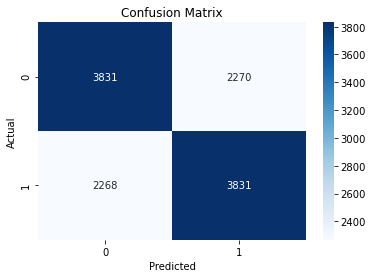

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [49]:
import joblib

joblib.dump(rr, "nba_model.pkl")

joblib.dump(predictors, "predictors.pkl")

['predictors.pkl']

In [50]:
df

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,orb,...,usg%_max_opp_10,ortg_max_opp_10,drtg_max_opp_10,total_opp_10,home_opp_10,won_10,season_10,home_next,team_opp_next,date_next
222,0.0,0.477273,0.426230,0.483333,0.535714,0.698113,0.390646,0.431818,0.359375,0.321429,...,0.131667,0.336816,0.438710,0.326606,0.7,0.7,2018.0,1.0,UTA,2017-11-05
237,0.0,0.295455,0.409836,0.278571,0.285714,0.452830,0.287483,0.386364,0.343750,0.321429,...,0.192436,0.381592,0.364516,0.370642,0.4,0.1,2018.0,0.0,MIN,2017-11-04
244,0.0,0.431818,0.262295,0.564286,0.428571,0.264151,0.668501,0.340909,0.343750,0.285714,...,0.164231,0.322388,0.440860,0.313761,0.5,0.7,2018.0,1.0,IND,2017-11-08
245,0.0,0.431818,0.393443,0.454762,0.178571,0.264151,0.266850,0.500000,0.421875,0.321429,...,0.159487,0.437313,0.427957,0.360550,0.5,0.5,2018.0,1.0,BRK,2017-11-07
247,0.0,0.431818,0.393443,0.454762,0.321429,0.320755,0.431912,0.204545,0.187500,0.250000,...,0.189487,0.343781,0.350538,0.366055,0.5,0.1,2018.0,0.0,WAS,2017-11-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18357,0.0,0.295455,0.508197,0.221429,0.321429,0.566038,0.266850,0.272727,0.234375,0.571429,...,0.174744,0.485075,0.460215,0.250459,0.3,0.6,2025.0,NaN,NaN,NaN
18358,0.0,0.659091,0.426230,0.697619,0.535714,0.490566,0.533700,0.750000,0.562500,0.285714,...,0.163718,0.397512,0.573118,0.384404,0.5,0.8,2025.0,NaN,NaN,NaN
18359,0.0,0.363636,0.377049,0.383333,0.285714,0.396226,0.321871,0.181818,0.156250,0.357143,...,0.132308,0.339801,0.438710,0.346789,0.6,0.7,2025.0,NaN,NaN,NaN
18360,0.0,0.522727,0.393443,0.564286,0.535714,0.509434,0.517194,0.295455,0.312500,0.392857,...,0.162821,0.333333,0.520430,0.322018,0.5,0.7,2025.0,NaN,NaN,NaN


In [51]:
df.to_csv("processed_nba_data.csv", index=False)